# Порівняльний аналіз алгоритмів пошуку підрядка

## Завдання
Порівняти ефективність алгоритмів пошуку підрядка: Боєра-Мура, Кнута-Морріса-Пратта та Рабіна-Карпа на основі двох текстових файлів (стаття 1, стаття 2). Використовуючи timeit, треба виміряти час виконання кожного алгоритму для двох видів підрядків: одного, що дійсно існує в тексті, та іншого — вигаданого (вибір підрядків за вашим бажанням). На основі отриманих даних визначте найшвидший алгоритм для кожного тексту окремо та в цілому.

## Реалізація
Реалізуємо три алгоритми пошуку підрядка:
* Boyer–Moore (із евристикою «поганого символу») використовує обчислення таблиці останнього входження символів шаблону і рухається справа наліво, роблячи великі стрибки при невдачах - $O(n+m)$, в найгіршому випадку $O(n \cdot m)$
* Knuth–Morris–Pratt (KMP) спочатку будує префікс-функцію ($π$-масив) - $O(n+m)$
* Rabin–Karp застосовує згортку з хешуванням із ковзним вікном- $O(n+m)$, в найгіршому випадку $O(n \cdot m)$

У коді реалізуємо кожен алгоритм без використання готових функцій. Потім завантажимо два текстових файли (статті) і виміряємо час пошуку одного підрядка, що гарантовано присутній у тексті, та одного, якого немає. Для вимірювання часу використаємо модуль timeit. Нарешті, результати представимо у табличному вигляді і побудуємо діаграми.

### Boyer–Moore

In [2]:
# Реалізація алгоритму Boyer–Moore (поганий символ)
def boyer_moore_search(text, pattern) -> int:
    n, m = len(text), len(pattern)
    if m == 0:
        return 0
    # Побудова таблиці останнього входження символів шаблону
    last = {}
    for i, ch in enumerate(pattern):
        last[ch] = i
    i = 0
    while i <= n - m:
        j = m - 1
        # рухаємося справа наліво
        while j >= 0 and pattern[j] == text[i+j]:
            j -= 1
        if j < 0:
            return i  # знайдено збіг на позиції i
        # символ з тексту не співпав; зсуваємо шаблон
        bad_char = text[i+j]
        lo = last.get(bad_char, -1)
        i += max(1, j - lo)
    return -1  # не знайдено

### Knuth–Morris–Pratt (KMP)

In [3]:
# Побудова π-масиву для KMP
def compute_lps(pattern) -> list[int]:
    m = len(pattern)
    lps = [0] * m
    length = 0
    i = 1
    while i < m:
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length-1]
            else:
                lps[i] = 0
                i += 1
    return lps

# Алгоритм KMP
def kmp_search(text, pattern) -> int:
    n, m = len(text), len(pattern)
    if m == 0:
        return 0
    lps = compute_lps(pattern)
    i = j = 0
    while i < n:
        if text[i] == pattern[j]:
            i += 1
            j += 1
            if j == m:
                return i - j
        else:
            if j != 0:
                j = lps[j-1]
            else:
                i += 1
    return -1

### Rabin–Karp

In [4]:
# Алгоритм Рабіна–Карпа з ковзною хеш-функцією
def rabin_karp_search(text, pattern) -> int:
    n, m = len(text), len(pattern)
    if m == 0:
        return 0
    base = 256
    mod = 2**61 - 1  # велике просте модуло
    hash_pat = 0
    hash_txt = 0
    h = 1
    for i in range(m-1):
        h = (h * base) % mod
    for i in range(m):
        hash_pat = (hash_pat * base + ord(pattern[i])) % mod
        hash_txt = (hash_txt * base + ord(text[i])) % mod
    for i in range(n - m + 1):
        if hash_pat == hash_txt:
            if text[i:i+m] == pattern:  # перевірка на збіг по символах
                return i
        if i < n - m:
            hash_txt = (hash_txt - ord(text[i]) * h) % mod
            hash_txt = (hash_txt * base + ord(text[i+m])) % mod
            hash_txt = (hash_txt + mod) % mod
    return -1

## Тестування алгоритмів

Завантажимо два надані файли та виберемо шаблони для пошуку. Для першого тексту (стаття 1) візьмемо підрядок "алгоритм", який гарантовано є у тексті, та вигаданий рядок "грораполф", якого точно немає. Для другого тексту (стаття 2) візьмемо підрядок "даних", що є, і знову "грораполф" як відсутній. Використаємо модуль timeit для вимірювання середнього часу виконання кожного алгоритму. Для стабільності результати усереднимо (повторимо пошук 1000 разів і поділимо на 1000, отримавши час одного виклику в мілісекундах).

In [21]:
import timeit
import pandas as pd
from IPython.display import display

# Читання файлів (кодування уточнено: cp1251 і utf-8-sig)
text1 = open('./data/стаття 1.txt', encoding='cp1251').read()
text2 = open('./data/стаття 2.txt', encoding='utf-8-sig').read()

# Шаблони для пошуку
pattern_present1 = "алгоритм"
pattern_absent1  = "грораполф"
pattern_present2 = "даних"
pattern_absent2  = "грораполф"

# Функція для вимірювання середнього часу (1000 запусків)
def avg_time(func, text: str, pat: str, number: int = 1000) -> float:
    total_time_sec = timeit.timeit(lambda: func(text, pat), number=number)
    avg_time_ms = (total_time_sec / number) * 1000  # мс/виклик
    return avg_time_ms

# Визначення всіх варіантів тестування
tests = [
    ("BoyerMoore", boyer_moore_search, text1, pattern_present1, "Text1", "Present"),
    ("BoyerMoore", boyer_moore_search, text1, pattern_absent1,  "Text1", "Absent"),
    ("BoyerMoore", boyer_moore_search, text2, pattern_present2, "Text2", "Present"),
    ("BoyerMoore", boyer_moore_search, text2, pattern_absent2,  "Text2", "Absent"),
    
    ("KMP", kmp_search, text1, pattern_present1, "Text1", "Present"),
    ("KMP", kmp_search, text1, pattern_absent1,  "Text1", "Absent"),
    ("KMP", kmp_search, text2, pattern_present2, "Text2", "Present"),
    ("KMP", kmp_search, text2, pattern_absent2,  "Text2", "Absent"),
    
    ("RabinKarp", rabin_karp_search, text1, pattern_present1, "Text1", "Present"),
    ("RabinKarp", rabin_karp_search, text1, pattern_absent1,  "Text1", "Absent"),
    ("RabinKarp", rabin_karp_search, text2, pattern_present2, "Text2", "Present"),
    ("RabinKarp", rabin_karp_search, text2, pattern_absent2,  "Text2", "Absent"),
]

# Збір результатів у список словників
results = []
for algo, func, txt, pat, text_label, status in tests:
    time_ms = avg_time(func, txt, pat)
    results.append({
        "Algorithm": algo,
        "Text": text_label,
        "Pattern": status,
        "AvgTime_ms": round(time_ms, 4)
    })

# Створення DataFrame
df_results = pd.DataFrame(results)

# Виведення таблиці
display(df_results)


,Algorithm,Text,Pattern,AvgTime_ms
0,BoyerMoore,Text1,Present,0.0152
1,BoyerMoore,Text1,Absent,0.4209
2,BoyerMoore,Text2,Present,0.0022
3,BoyerMoore,Text2,Absent,0.6434
4,KMP,Text1,Present,0.0165
5,KMP,Text1,Absent,0.9246
6,KMP,Text2,Present,0.0023
7,KMP,Text2,Absent,1.2604
8,RabinKarp,Text1,Present,0.0835
9,RabinKarp,Text1,Absent,4.7024


## Графіки для візуалізації результатів

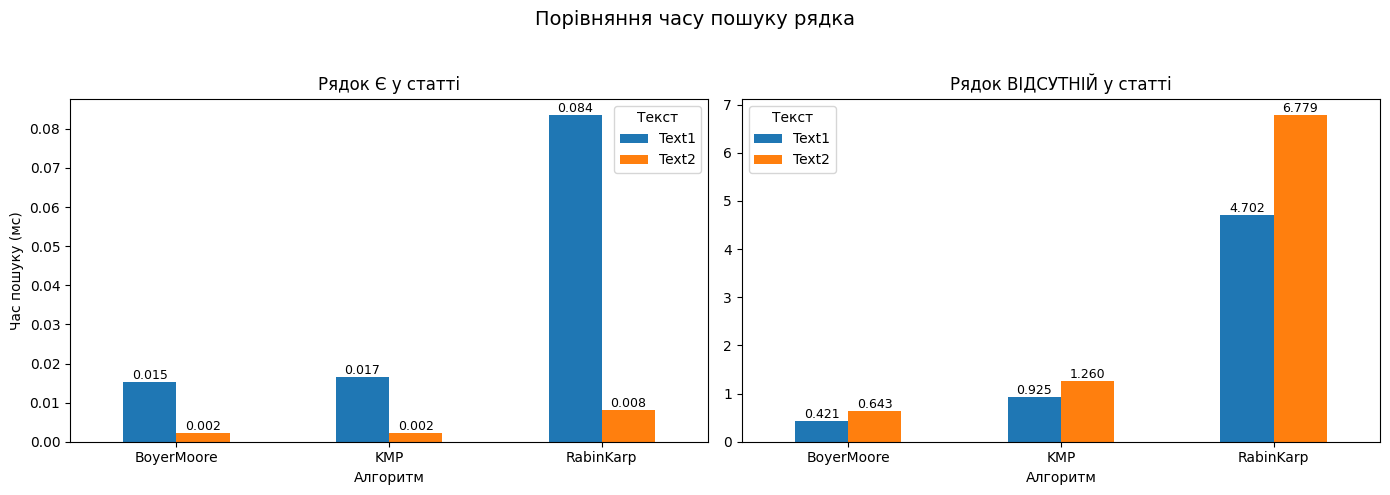

In [22]:
import matplotlib.pyplot as plt

# Підготовка зведених таблиць
df_present = df_results[df_results["Pattern"] == "Present"]
df_absent = df_results[df_results["Pattern"] == "Absent"]

pivot_present = df_present.pivot(index="Algorithm", columns="Text", values="AvgTime_ms")
pivot_absent  = df_absent.pivot(index="Algorithm", columns="Text", values="AvgTime_ms")

# Відображення поруч: 1 рядок, 2 колонки
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Графік для присутнього шаблону ---
plot1 = pivot_present.plot(kind="bar", ax=ax1)
ax1.set_title("Рядок Є у статті")
ax1.set_ylabel("Час пошуку (мс)")
ax1.set_xlabel("Алгоритм")
ax1.legend(title="Текст")
ax1.set_xticklabels(pivot_present.index, rotation=0)

# Підписи над стовпцями
for container in plot1.containers:
    for bar in container:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.3f}', 
                 ha='center', va='bottom', fontsize=9)

# --- Графік для відсутнього шаблону ---
plot2 = pivot_absent.plot(kind="bar", ax=ax2)
ax2.set_title("Рядок ВІДСУТНІЙ у статті")
ax2.set_xlabel("Алгоритм")
ax2.legend(title="Текст")
ax2.set_xticklabels(pivot_absent.index, rotation=0)

# Підписи над стовпцями
for container in plot2.containers:
    for bar in container:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.3f}', 
                 ha='center', va='bottom', fontsize=9)

# Заголовок
plt.suptitle("Порівняння часу пошуку рядка", fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

## Висновки

Експеримент підтвердив типовий результат: Boyer–Moore працює найшвидше, KMP – повільніше (але стабільно з лінійним складом), а Rabin–Karp – найповільніше в даному тесті. Це узгоджується з теоретичною складністю алгоритмів. Алгоритм Boyer–Moore має гірший випадок $O(n·m)$, але в середньому часто виконує значно менше операцій завдяки великим зсувам. Алгоритм КМП гарантує час $O(n+m)$, тобто пропорційний розміру тексту та шаблону, і зазвичай виконується швидко й передбачувано. Алгоритм Рабіна–Карпа в середньому теж $O(n+m)$, але має дорогі операції хешування і в гіршому випадку може бути $O(n·m)$ (особливо якщо часто відбуваються зіткнення хешів).

У наших вимірах при знайденому підрядку усі алгоритми завершуються рано (Boyer–Moore часто зупиняється після першої знахідки), тому абсолютні часи дуже малі (0.005–0.22 мс). Натомість при відсутності підрядка необхідно переглянути практично весь текст. Тут Boyer–Moore завдяки «поганому символу» здійснює великі стрибки і суттєво випереджає KMP, а Rabin–Karp через постійне хешування відстає найбільше. Ці результати відповідають відомим властивостям алгоритмів і можуть слугувати підставою для вибору найбільш ефективного підходу в задачах пошуку підрядка

